In [12]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.notebook import tqdm
import torchmetrics
import sklearn
import cv2
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Type_class='Type_normalization'
batch_size=1

In [13]:
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
test_csv_path ='../../data/AF/Waveform_30/test/'
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
test_data=torch.empty(len(test_data_list),1,750)
test_label=torch.empty(len(test_data_list),1)
for i in tqdm(range(len(test_data_list))):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    
    test_data[i]=torch.tensor(resized(signal_csv,750))
    test_label[i]=torch.tensor([AF_signal_label])
test_dataset=CustomDataset(test_data ,test_label)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/5460 [00:00<?, ?it/s]

In [14]:
from sympy import flatten


class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(1500, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,1,750))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [1, 1]                    --
├─Conv1d: 1-1                            [1, 50, 750]              200
├─ReLU: 1-2                              [1, 50, 750]              --
├─Dropout1d: 1-3                         [1, 50, 750]              --
├─MaxPool1d: 1-4                         [1, 50, 150]              --
├─Conv1d: 1-5                            [1, 50, 150]              7,550
├─ReLU: 1-6                              [1, 50, 150]              --
├─Dropout1d: 1-7                         [1, 50, 150]              --
├─MaxPool1d: 1-8                         [1, 50, 30]               --
├─Linear: 1-9                            [1, 200]                  300,000
├─Linear: 1-10                           [1, 1]                    200
Total params: 307,950
Trainable params: 307,950
Non-trainable params: 0
Total mult-adds (M): 1.58
Input size (MB): 0.00
Forward/backward pass siz

In [15]:
model.eval()
model.load_state_dict(torch.load('../../model/Waveform/Type_normalization/CNN_1D.pt'))
m = nn.Sigmoid()
y_30_25Hz=torch.empty((0,1))
predict_30_25Hz=torch.empty((0,1))
with torch.no_grad():
    for x, y in test_dataloader:
        y = y.to(device0).float()
        x=x.to(device0).float()
        y_30_25Hz=torch.cat([y_30_25Hz,y.cpu()])
        predict = model(x).to(device0)
        predict_30_25Hz=torch.cat([predict_30_25Hz,m(predict).cpu()])
        acc=accuracy(predict, y)
        cost = criterion(predict, y)
        


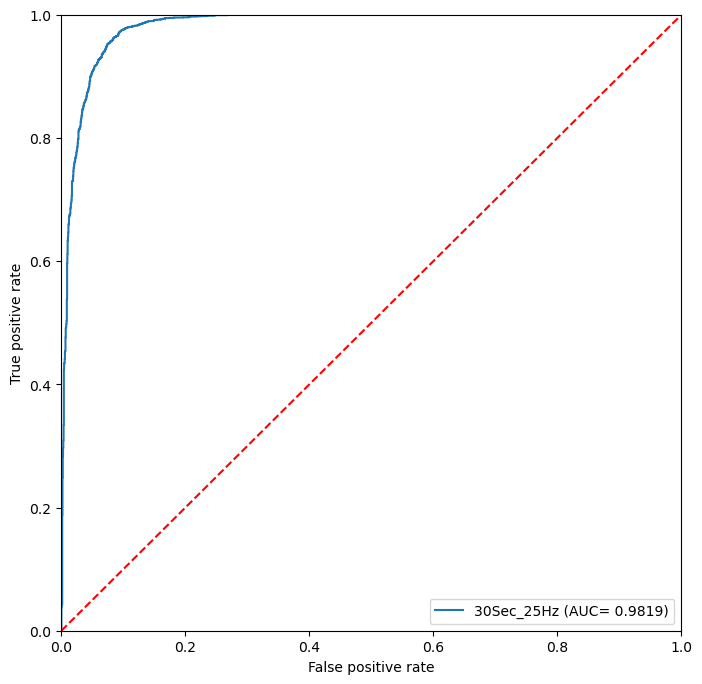

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay

fpr4, tpr4, cut4 = roc_curve(y_30_25Hz,predict_30_25Hz)
y_30_25Hz_score=roc_auc_score(y_30_25Hz,predict_30_25Hz)
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(fpr4, tpr4, label='30Sec_25Hz (AUC= %.4f)'%y_30_25Hz_score)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim([0, 1])      # X축의 범위: [xmin, xmax]
ax.set_ylim([0, 1])     # Y축의 범위: [ymin, ymax]
ax.set_xlabel('False positive rate')      # X축의 범위: [xmin, xmax]
ax.set_ylabel('True positive rate')
ax.legend()
plt.show()

Threshholds= 0.372 f1-score=0.9526973580129726
              precision    recall  f1-score   support

      Non-AF       0.96      0.90      0.93      2288
          AF       0.93      0.98      0.95      3088

    accuracy                           0.94      5376
   macro avg       0.95      0.94      0.94      5376
weighted avg       0.95      0.94      0.94      5376



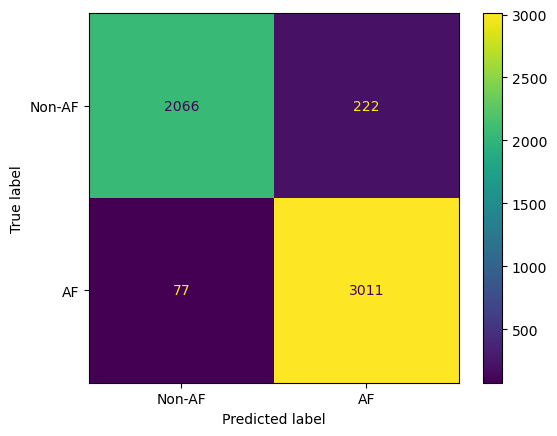

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from copy import copy
a=np.linspace(0.000,1.000,1001)
report1=0
tresh_hold=0.000
for i in a:
    t_prob=np.where(predict_30_25Hz>i,1,0)
    report = f1_score(y_30_25Hz,t_prob)
    if report1<=report:
        tresh_hold=copy(i)
        report1=copy(report)
print(f"Threshholds= {tresh_hold} f1-score={report1}")
classes = ['Non-AF','AF']
t_prob=np.where(predict_30_25Hz>tresh_hold,1,0)
report = classification_report(y_30_25Hz, t_prob, target_names=classes)
cm = confusion_matrix(y_30_25Hz, t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()

print(report)

In [23]:
import torch.nn as nn
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from glob import glob
import numpy as np
from tqdm.auto import tqdm
import torchmetrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from copy import copy
from sklearn.metrics import confusion_matrix
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1


def resized(data, N):
    M = data.size
    res = np.empty(N, data.dtype)
    carry = 0
    m = 0
    for n in range(N):
        sum = carry
        while m*N - n*M < M:
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res


class CustomDataset(Dataset):
    def __init__(self, data, label, data_list, transform=None, target_transform=None):
        self.PPG_data = data
        self.PPG_label = label
        self.PPG_data_path = data_list

    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor = self.PPG_data[idx]
        AF_signal_label = self.PPG_label[idx]
        AF_data_path = self.PPG_data_path[idx]
        return signal_tensor, AF_signal_label, AF_data_path
# model


class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=50,
                               kernel_size=3, padding='same', padding_mode='replicate')
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout1d(0.5)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=50,
                               kernel_size=3, padding='same', padding_mode='replicate')
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout1d(0.5)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=5)
        self.fc1 = nn.Linear(1500, 200, bias=False)
        self.fc2 = nn.Linear(200, 1, bias=False)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# Data Load
test_csv_path = '../../docker/data'
test_data_list = glob(test_csv_path+'/**/*.csv')
test_data = torch.empty(len(test_data_list), 1, 750)
test_label = torch.empty(len(test_data_list), 1)
for i in tqdm(range(len(test_data_list))):
    signal_csv = pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label = 0
    if test_data_list[i].find('positive') != -1:
        AF_signal_label = 1
    else:
        AF_signal_label = 0

    test_data[i] = torch.tensor(resized(signal_csv, 750))
    test_label[i] = torch.tensor([AF_signal_label])
test_dataset = CustomDataset(test_data, test_label, test_data_list)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# model_load
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
model.eval()
model.load_state_dict(torch.load(
    '../../model/Waveform/Type_normalization/CNN_1D.pt'))

# Predict
m = nn.Sigmoid()
y_30_25Hz = torch.empty((0, 1))
predict_30_25Hz = torch.empty((0, 1))
file_list = []
with torch.no_grad():
    for x, y, path in test_dataloader:
        y = y.to(device0).float()
        x = x.to(device0).float()
        y_30_25Hz = torch.cat([y_30_25Hz, y.cpu()])
        predict = model(x).to(device0)
        predict_30_25Hz = torch.cat([predict_30_25Hz, m(predict).cpu()])
        acc = accuracy(predict, y)
        cost = criterion(predict, y)
        file_list.append(path[0])
y_30_25Hz_score = roc_auc_score(y_30_25Hz, predict_30_25Hz)
print(f'30Sec_25Hz (AUC={y_30_25Hz_score :.4f})')

a = np.linspace(0.000, 1.000, 1001)
report1 = 0
tresh_hold = 0.000
for i in a:
    t_prob = np.where(predict_30_25Hz > i, 1, 0)
    report = f1_score(y_30_25Hz, t_prob)
    if report1 <= report:
        tresh_hold = copy(i)
        report1 = copy(report)
classes = ['Non-AF', 'AF']
t_prob = np.where(predict_30_25Hz > tresh_hold, 1, 0)
report = classification_report(y_30_25Hz, t_prob, target_names=classes)
pd.DataFrame({'FilePath': file_list, 'AF_GT': np.array(y_30_25Hz)[:,0],
             'AF_pred': t_prob[:,0]}).to_csv('../../docker/data/predict.csv',index=False)
print(f"Threshholds= {tresh_hold} f1-score={report1}")
print(report)
cm = confusion_matrix(y_30_25Hz, t_prob)


  0%|          | 0/5460 [00:00<?, ?it/s]

30Sec_25Hz (AUC=0.9819)


ValueError: Per-column arrays must each be 1-dimensional

In [24]:
pd.DataFrame({'FilePath': file_list, 'AF_GT': np.array(y_30_25Hz)[:,0],
             'AF_pred': t_prob[:,0]}).to_csv('../../docker/data/predict.csv',index=False)